In [155]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns


from scipy.io import loadmat, savemat
from scipy.stats import pearsonr, spearmanr, sem, ttest_rel, ttest_1samp
from scipy.stats.mstats import winsorize
from pingouin import rm_anova


from statannotations.Annotator import Annotator
from itertools import combinations
from collections import Counter

import sys
sys.path.append('../../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *


import pickle
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set up directories

In [156]:

train = 'listen'

mapchange_dir = '../mapchange_csv_corrected_since_bymap_till/'
pred_dir = f'./rTRF_predictions_{train}'
sv_dir ='./sv/'
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()



In [157]:
xtick_fontsize = 15
axis_fontsize = 20

## Visualize individual predictions

In [158]:
# subject = '06'
# period = 'post'

# # pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
# # pred_stim = pred_data['predicted_stim'][0]
# # pred_corr = pred_data['pearsonr']
# # sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0]
# # sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0]

# # print(pred_corr)

# pred_stim_winsorized = winsorize(pred_stim, limits = [0.005, 0.005])

In [159]:
# plt.figure(figsize = (15,5))
# plt.plot(sv_firsts/8, label = 'scaled ground truth')
# plt.plot(pred_stim_winsorized, alpha = 0.8, label = 'pred')
# plt.title(f'{subject} {period}')
# plt.legend()

# plt.xlim(30000,40000)

In [160]:
# pearsonr(pred_stim_winsorized, sv_onsets)

## Correlate with support vectors

In [161]:

periods =[ 'pre', 'post']
subjects_to_process =  good_error_subjects

pearson_o_stat = []
pearson_o_p = []
pearson_shuf_stat = []
pearson_shuf_p = []

corr_sv_df = pd.DataFrame()

for subject in subjects_to_process:
    for period in periods:

        sub_df = {
            'subject': subject,
            'period': period
        }
    # print(subject)
        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]
        # print(pred_stim.shape)

        #load support vectors
        sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
        sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0] 

        if sv_firsts.shape[0]>pred_stim.shape[0]:
            # sv_firsts = sv_firsts[:pred_stim.shape[0]]
            sv_onsets = sv_onsets[:pred_stim.shape[0]]

        
        #correlation with support vectors
        try:
            #correlation with onsets
            res_o = pearsonr(pred_stim, sv_onsets) 
            sub_df['pearson_onsets_stat'] = res_o.statistic
            sub_df['pearson_onsets_p'] = res_o.pvalue
            # pearson_o_stat.append(res_o.statistic)
            # pearson_o_p.append(res_o.pvalue)

            #correlation with shuffled onsets
            res_o_shuf = pearsonr(pred_stim, np.random.permutation(sv_onsets))
            sub_df['pearson_shuffled_stat'] = res_o_shuf.statistic
            sub_df['pearson_shuffled_p'] = res_o_shuf.pvalue
            # pearson_shuf_stat.append(res_o_shuf.statistic)
            # pearson_shuf_p.append(res_o_shuf.pvalue)

            corr_sv_df = pd.concat([corr_sv_df, pd.DataFrame([sub_df])], ignore_index=True)
        except ValueError: 
            print('ValueError at subject', subject)
            continue



# corr_sv_df = pd.DataFrame({
#     'subject': subjects_to_process,
#     'pearson_onsets_stat': pearson_o_stat,
#     'pearson_onsets_p': pearson_o_p,
#     'pearson_shuffled_stat': pearson_shuf_stat,
#     'pearson_shuffled_p': pearson_shuf_p
# })

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post_pearson_onsets_stat vs. post_pearson_shuffled_stat: Custom statistical test, P_val:7.629e-06
pre_pearson_onsets_stat vs. pre_pearson_shuffled_stat: Custom statistical test, P_val:7.629e-06


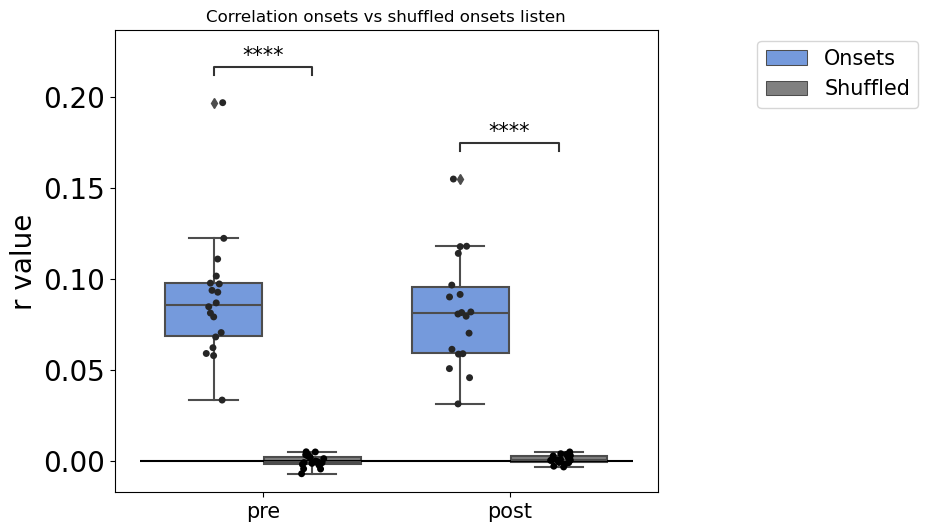

In [163]:
plt.figure(figsize = (7,6))
colours = {
    'pearson_onsets_stat': 'cornflowerblue',
    'pearson_shuffled_stat': 'grey'
}

corr_sv_df_sns = pd.melt(corr_sv_df, id_vars = ['subject', 'period'], value_vars = ['pearson_onsets_stat', 'pearson_shuffled_stat'], var_name = 'correlation_type', value_name = 'correlation_value')
ax = sns.boxplot(corr_sv_df_sns, x = 'period', y = 'correlation_value', hue = 'correlation_type', palette = colours)
sns.stripplot(corr_sv_df_sns, x = 'period', y = 'correlation_value', hue = 'correlation_type', color = 'black', dodge = True)



#stat annotations
pairs = [(('pre','pearson_onsets_stat'), ('pre','pearson_shuffled_stat')),
         (('post','pearson_onsets_stat'), ('post','pearson_shuffled_stat'))]

#manually calculate p values
_, p_pre = wilcoxon(corr_sv_df.query('period == "pre"')['pearson_onsets_stat'], corr_sv_df.query('period == "pre"')['pearson_shuffled_stat'])
_, p_post = wilcoxon(corr_sv_df.query('period == "post"')['pearson_onsets_stat'], corr_sv_df.query('period == "post"')['pearson_shuffled_stat'])

annotator = Annotator(ax, pairs, data=corr_sv_df_sns, x='period', y='correlation_value', hue = 'correlation_type')
annotator.configure(text_format='star', loc='inside', fontsize=15)
annotator.set_pvalues([p_pre, p_post])

annotator.annotate()


ax = plt.gca()
# ax.set_xlabel('')
# ax.set_ylabel('correlation coefficient', fontsize = axis_fontsize)
ax.set_xticklabels(['pre', 'post'], fontsize = xtick_fontsize)
plt.title(f'Correlation onsets vs shuffled onsets {train}')
plt.ylabel('r value', fontsize = axis_fontsize)
plt.xlabel('')
plt.yticks(fontsize = axis_fontsize)
plt.hlines(0, -0.5, 1.5, color = 'black')
plt.legend(title = '', fontsize = xtick_fontsize,  bbox_to_anchor=(1.5, 1))

# Rename legend entries manually
label_map = {
    'pearson_onsets_stat': 'Onsets',
    'pearson_shuffled_stat': 'Shuffled'
}
handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(l, l) for l in labels]
ax.legend(handles[:2], new_labels[:2], title='', fontsize=xtick_fontsize, bbox_to_anchor=(1.5, 1))

plt.savefig(f'../figs/corr_onsets_shuffled_{train}.svg')

In [53]:
# pearson_o = []
# pearson_f = []
# winsorize_preds  = True
# invert = False

# good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

# #subjects_to_process =  ['06', '07', '08', '09', '10', '11', '12']
# subjects_to_process =  good_error_subjects


# for subject in subjects_to_process:
#     print(subject)
#     pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
#     pred_stim = pred_data['predicted_stim'][0]
#     print(pred_stim.shape)

#     if winsorize_preds: 
#         pred_stim = winsorize(pred_stim, limits = [0.005, 0.005])

#     #load support vectors
#     sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
#     sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0] 

#     if sv_firsts.shape[0]>pred_stim.shape[0]:
#         # sv_firsts = sv_firsts[:pred_stim.shape[0]]
#         sv_onsets = sv_onsets[:pred_stim.shape[0]]

    
#     #correlation with support vectors
#     print(pred_stim.shape, sv_onsets.shape)

#     try:
#         res_o = pearsonr(pred_stim, sv_onsets) 
#         res_f = pearsonr(pred_stim, sv_firsts)

#         pearson_o.append(res_o)
#     except ValueError: 
#         continue
#     # pearson_f.append(res_f)

#     #plt.plot([1,2], [res_o.statistic, res_f.statistic])

# # pearson_f = np.array(pearson_f)
# pearson_o = np.array(pearson_o)
# # pearson_diff = pearson_f - pearson_o
# print(pearson_o)


In [8]:
# # pearson_o = []
# # pearson_f = []

# corr_data = []
# winsorize_preds  = True
# invert = False
# sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
# period = 'post' #post has good results

# good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
# #subjects_to_process =  ['06', '07', '08', '09', '10', '11', '12']
# subjects_to_process =  good_error_subjects


# for subject in subjects_to_process:
#     sub_data = {
#         'subject':subject,
#         'period':period,
#         }
    
#     pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
#     pred_stim = pred_data['predicted_stim'][0]

#     if winsorize_preds: 
#         pred_stim = winsorize(pred_stim, limits = [0.005, 0.005])

#     #load onset support vector
#     sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
#     if sv_onsets.shape[0]>pred_stim.shape[0]:
#         sv_onsets = sv_onsets[:pred_stim.shape[0]]
#     if invert:
#         sv_onsets = sv_onsets*-1
#     res_o = pearsonr(pred_stim, sv_onsets) 
#     sub_data['onset_raw'] = res_o.statistic

#     #loop through other support vectors
#     for sv in sv_to_test:
#         sv_tocompare = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))[sv][0] 

#         if sv_tocompare.shape[0]>pred_stim.shape[0]:
#             sv_tocompare = sv_tocompare[:pred_stim.shape[0]]
            
            
#         if invert:
            
#             sv_tocompare = sv_tocompare*-1

        
#         #correlation with support vectors
        
#         res_f = pearsonr(pred_stim, sv_tocompare)
#         diff = res_f.statistic - res_o.statistic

#         sub_data[sv] = diff
#         sub_data[sv+'_raw'] = res_f.statistic
        
#     corr_data.append(sub_data)

# corr_data = pd.DataFrame(corr_data)


In [9]:
# corr_data_toplot = corr_data.melt(id_vars = ['subject', 'period'],
#                                   value_vars = sv_to_test,
#                                   value_name = 'diff',
#                                   var_name='sv_type',
                                  
# )

In [10]:
# sns.set_palette('rocket')

# plt.figure(figsize = (8,6))
# ax = sns.boxplot(data = corr_data_toplot, x = 'sv_type', y = 'diff')
# ax = sns.stripplot(data = corr_data_toplot, x = 'sv_type', y = 'diff', color = 'black')

# #pairwise comparisons between categories
# pairs = list(combinations(sv_to_test, 2))
# p_values_dict = {pair:ttest_rel(corr_data[pair[0]],
#                                   corr_data[pair[1]]).pvalue 
#             for pair in pairs}

# annotator = Annotator(ax, pairs, data=corr_data_toplot, x='sv_type', y='diff')

# p_values = list(p_values_dict.values())
# annotator.set_pvalues(p_values)
# annotator.annotate()

# #test all categories against 0
# pairs = [(sv_type,sv_type) for sv_type in sv_to_test]

# annotator_1samp = Annotator(ax, pairs, data=corr_data_toplot, x='sv_type', y='diff')

# p_values_1samp = []
# for sv_type in sv_to_test:
#     group_data = corr_data[sv_type]
#     t_stat, p_val = wilcoxon_1samp(group_data)
#     p_values_1samp.append(p_val)
# annotator_1samp.set_pvalues(p_values_1samp)

# annotator_1samp.annotate(line_offset_to_group=0.4)

# plt.title(f'Difference in Pearson r vs onset, {period}')
# plt.ylabel('Difference vs onset')
# plt.xticks([0,1,2,3], labels = ['Firsts', 'Firsts surprisal', 'Others surprisal', 'F and O surprisal' ])
# plt.xlabel('')

## Correlate with training scores

In [11]:
#subjects_to_process = ['06', '07', '08', '09', '10', '11', '12']
#scores_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/training_scores_rank.csv') 

In [12]:
# pearsonrs = []
# for subject in subjects_to_process:
#     pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
#    # pred_stim = pred_data['predicted_stim']
#     pred_corr = pred_data['pearsonr']
#     pearsonrs.append(pred_corr[0][0])



## Firsts vs others

(0.0, 250.0)

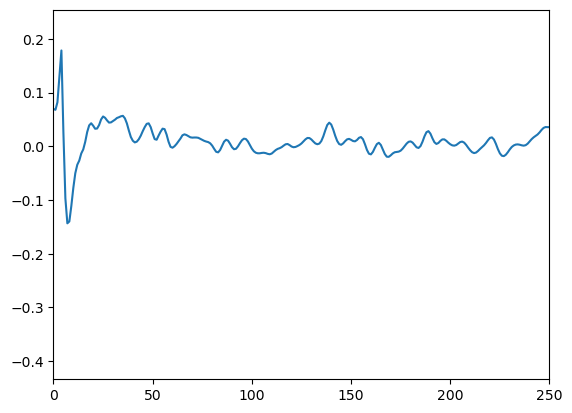

In [46]:
subject = '06'
period = 'pre'
pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
pred_stim = pred_data['predicted_stim'][0]
plt.plot(pred_stim)
plt.xlim(0,250)

In [120]:
# periods = ['post']
periods = ['pre', 'post']
pred_amp_df = []
# subjects_to_process = ['01','04','05','06','07','08','09','10','11','12']
subjects_to_process = good_error_subjects

for subject in subjects_to_process:
    print(subject)
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }
        
        #look at predictions on post using pre models
        # pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_datapost_modelpre.mat'))
        
        #look at predictions with time-matched models
        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]

        #find times for keystrokes
        fo_df = pd.read_csv(os.path.join(mapchange_dir,f'mapchange_keystrokes_{period}_{subject}.csv'))
        others_times = fo_df[fo_df['type']=='other']['time']
        firsts_times = fo_df[fo_df['type']=='first']['time']

        #compare reconstructed amplitudes at keystrokes
        amp_others = pred_stim[others_times].mean()
        amp_firsts = pred_stim[firsts_times].mean()

        sub_data['others'] = amp_others
        sub_data['firsts'] = amp_firsts
    
        pred_amp_df.append(sub_data)    

pred_amp_df = pd.DataFrame(pred_amp_df)



01
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20


In [121]:
pred_amp_df['diff'] = pred_amp_df['firsts'] - pred_amp_df['others']

pred_amp_df_melt = pred_amp_df.melt(id_vars=['subject', 'period'], 
                 value_vars = ['others', 'firsts'], 
                 value_name = 'pred_amp',
                 var_name='type')

In [122]:

anova_res = rm_anova(data = pred_amp_df_melt, dv = 'pred_amp', within = ['period', 'type'], subject = 'subject')
anova_res


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,period,0.000006,1,17,0.000006,0.360098,0.556367,0.556367,0.002312,1.0
1,type,0.000010,1,17,0.000010,6.531205,0.020472,0.020472,0.003788,1.0
2,period * type,0.000002,1,17,0.000002,0.699064,0.414696,0.414696,0.000590,1.0


In [123]:
# pred_svg = loadmat('./rTRF_predictions_listen/pred_err_09_pre.mat')['predicted_stim']
# mapchange_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since/mapchange_keystrokes_pre_09.csv') 

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post_others vs. post_firsts: Custom statistical test, P_val:7.690e-03
pre_others vs. pre_firsts: Custom statistical test, P_val:6.095e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Wilcoxon test (paired samples), P_val:2.928e-01 Stat=2.650e+02


/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

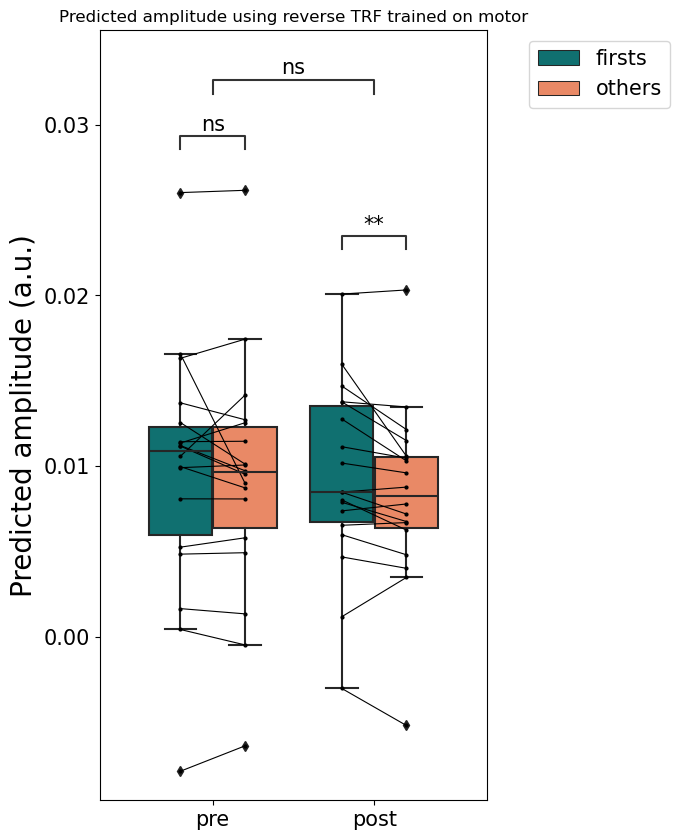

In [125]:
plt.figure(figsize = (5,10))

fo_colours = {'firsts': 'teal', 'others': 'coral'}
ax = sns.boxplot(data = pred_amp_df_melt, x = 'period', y = 'pred_amp', hue = 'type', hue_order=['firsts', 'others'], palette=fo_colours)

#plot individual subject lines
for period in periods:
    if period == 'pre':
        x_pos =  [-0.2, 0.2]
    elif period == 'post':
        x_pos = [0.8, 1.2]

    for subject in subjects_to_process:

        amp_toplot = pred_amp_df_melt.query(f'subject == "{subject}" and period == "{period}"')
        amp_firsts = amp_toplot.query(f'type == "firsts"')['pred_amp'].values[0]
        amp_others = amp_toplot.query(f'type == "others"')['pred_amp'].values[0]
    
        ax.plot(x_pos, [amp_firsts, amp_others], color = 'black', marker = 'o', markersize = 2, linewidth = 0.8)


_, p_pre = wilcoxon(pred_amp_df_melt.query('period == "pre" & type == "firsts"')['pred_amp'], pred_amp_df_melt.query('period == "pre" & type == "others"')['pred_amp'])
_, p_post = wilcoxon(pred_amp_df_melt.query('period == "post" & type == "firsts"')['pred_amp'], pred_amp_df_melt.query('period == "post" & type == "others"')['pred_amp'])


#firsts vs others within the period
pairs = [(('pre', 'firsts'), ('pre', 'others')),(('post', 'firsts'), ('post', 'others'))]
annotator = Annotator(ax, pairs, data=pred_amp_df_melt, x='period', y='pred_amp', hue='type')
annotator.set_pvalues([p_pre, p_post])
annotator.configure(fontsize=15)
annotator.annotate()

#Pre vs post main effect
pairs = [("pre", "post")]
annot = Annotator(ax, pairs, data=pred_amp_df_melt, x='period', y='pred_amp')
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, fontsize = 15)
annot.apply_and_annotate()



plt.legend(title = '', fontsize = xtick_fontsize,  bbox_to_anchor=(1.5, 1))
plt.ylabel('Predicted amplitude')
plt.title('Predicted amplitude using reverse TRF trained on motor')
plt.ylabel('Predicted amplitude (a.u.)', fontsize = axis_fontsize)
plt.yticks(fontsize = xtick_fontsize)
plt.title(f'Predicted amplitude using reverse TRF trained on {train}')
plt.xlabel('')
plt.xticks(fontsize = xtick_fontsize)
plt.savefig(f'../figs/pred_prepost_{train}.svg')

/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

others vs. firsts: Custom statistical test, P_val:7.690e-03


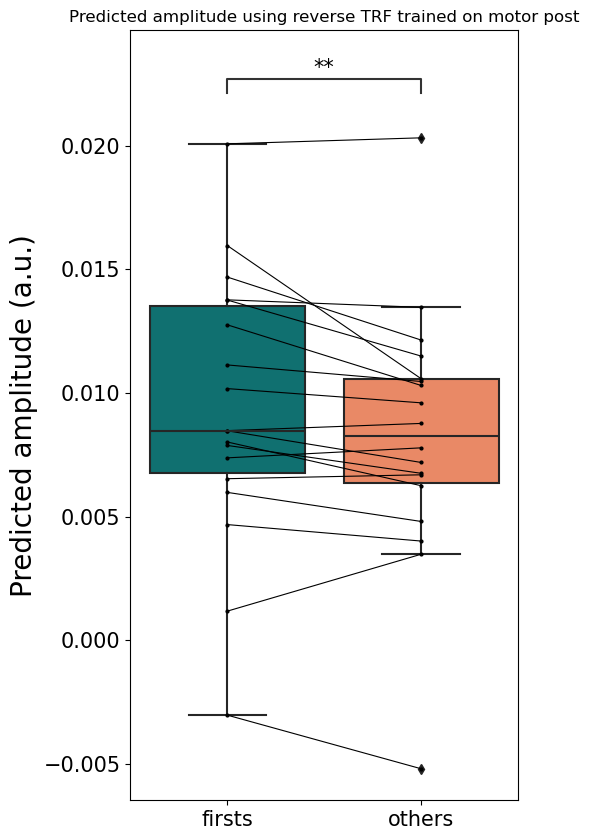

In [126]:
plt.figure(figsize=(5,10))
period = 'post'
p_value_toplot = p_post
pred_amp_df_melt_per = pred_amp_df_melt[pred_amp_df_melt['period'] == period]

fo_colours = {'firsts': 'teal', 'others': 'coral'}
order = ['firsts', 'others']
ax = sns.boxplot(data=pred_amp_df_melt_per, x='type', y='pred_amp', palette=fo_colours, order = order)

#plot individual subjects
x_pos = [0,1]

for subject in subjects_to_process:

    amp_toplot = pred_amp_df_melt.query(f'subject == "{subject}" and period == "{period}"')
    amp_firsts = amp_toplot.query(f'type == "firsts"')['pred_amp'].values[0]
    amp_others = amp_toplot.query(f'type == "others"')['pred_amp'].values[0]

    ax.plot(x_pos, [amp_firsts, amp_others], color = 'black', marker = 'o', markersize = 2, linewidth = 0.8)


# Define pairs for annotation
pairs = [('firsts', 'others')]  # Adjust according to your 'type' values

# Initialize and apply annotations
annotator = Annotator(ax, pairs, data=pred_amp_df_melt_per, x='type', y='pred_amp')
annotator.set_pvalues([p_value_toplot]) 
annotator.configure(fontsize=15)
annotator.annotate()

# Adjust plot labels and title
plt.ylabel('Predicted amplitude (a.u.)', fontsize = axis_fontsize)
plt.yticks(fontsize = xtick_fontsize)
plt.title(f'Predicted amplitude using reverse TRF trained on {train} {period}')
plt.xlabel('')
plt.xticks(fontsize = xtick_fontsize)

plt.savefig(f'../figs/pred_{period}_{train}.svg')

## Reconstructed stim window

In [127]:
mapchange_dir_bymap = '../mapchange_csv_corrected_since_bymap_till/'

periods = ['pre', 'post']
pred_amp_df_window = []
subjects_to_process = ['01','04','05','06','07','08','09','10','11','12']
window = 20
map_to_plot = 'inv'

for subject in subjects_to_process:
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }

        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]
        
        fo_df = pd.read_csv(os.path.join(mapchange_dir_bymap,f'mapchange_keystrokes_{period}_{subject}.csv'))

        #find times for keystrokes
        if map_to_plot == 'all_maps':
            others_times = fo_df[fo_df['type']=='other']['time']
            firsts_times = fo_df[fo_df['type']=='first']['time']

        else:
            others_times = fo_df[(fo_df['type']=='other') & (fo_df['prev_map'] == map_to_plot)]['time']
            firsts_times = fo_df[(fo_df['type']=='first') & (fo_df['prev_map'] == map_to_plot)]['time']

        # Get slices around each time point 
        window_others = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in others_times])
        window_firsts = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in firsts_times])

        #average to get mean window shape
        sub_data['others'] = np.expand_dims(np.mean(window_others, axis = 0), axis = 0)
        sub_data['firsts'] = np.expand_dims(np.mean(window_firsts, axis = 0), axis = 0)


    
        pred_amp_df_window.append(sub_data)    

pred_amp_df_window = pd.DataFrame(pred_amp_df_window)

In [128]:
period = 'post'
mean_firsts, sem_firsts = find_mean_sem_evs(pred_amp_df_window.query(f'period == "{period}"'), 0, col_to_ave='firsts')
mean_others, sem_others = find_mean_sem_evs(pred_amp_df_window.query(f'period == "{period}"'), 0, col_to_ave='others')

(array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 [Text(-0.2, 0, '−0.20'),
  Text(-0.15000000000000002, 0, '−0.15'),
  Text(-0.1, 0, '−0.10'),
  Text(-0.04999999999999999, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.04999999999999999, 0, '0.05'),
  Text(0.10000000000000003, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20')])

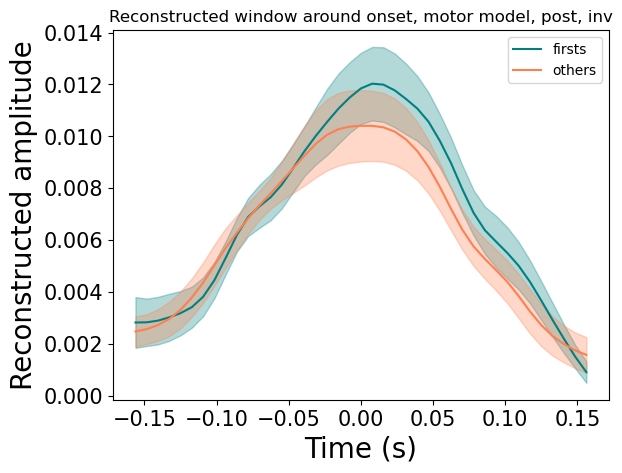

In [129]:
erp_times = create_erp_times(-0.15625, 0.15625, 128)
plot_mean_sem(erp_times, mean_firsts, sem_firsts, color = 'teal', label = 'firsts')
plot_mean_sem(erp_times, mean_others, sem_others, color = 'coral', label = 'others')
plt.legend()
plt.title(f'Reconstructed window around onset, {train} model, {period}, {map_to_plot}')
plt.ylabel('Reconstructed amplitude', fontsize = axis_fontsize)
plt.xlabel('Time (s)', fontsize = axis_fontsize)
plt.yticks(fontsize = xtick_fontsize)
plt.xticks(fontsize = xtick_fontsize)


## First vs other reconstruction by map

In [130]:
mapchange_dir_bymap = '../mapchange_csv_corrected_since_bymap_till/'

periods = ['pre', 'post']
pred_stim_data = []
subjects_to_process = good_error_subjects
window = 20
maps = ['inv', 'shinv', 'norm']
epoch_types = ['first', 'other']

for subject in subjects_to_process:
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }

        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]
        
        fo_df = pd.read_csv(os.path.join(mapchange_dir_bymap,f'mapchange_keystrokes_{period}_{subject}.csv'))

        # Loop over first and other
        for epoch_type in epoch_types:
            # All maps together
            times = fo_df[(fo_df['type'] == epoch_type)]['time']

            if len(times) > 0:
                window_data = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in times])
                sub_data[epoch_type] = np.expand_dims(np.mean(window_data, axis=0), axis=0)

            # Average windows separated by each new map
            for map_type in maps:

                if epoch_type == 'first': #first in the map for entering, first leaving the map for leaving
                    map_times = fo_df[(fo_df['type'] == epoch_type) & (fo_df['map'] == map_type)]['time']
                    prevmap_times = fo_df[(fo_df['type'] == epoch_type) & (fo_df['prev_map'] == map_type)]['time']
                elif epoch_type == 'other': #other in the map for both entering and leaving
                    map_times = fo_df[(fo_df['type'] == epoch_type) & (fo_df['map'] == map_type)]['time']
                    prevmap_times = map_times.copy()
                    
                if len(map_times) > 0:
                    map_window = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in map_times])
                    prevmap_window = np.array([pred_stim[max(0, t-window) : min(len(pred_stim), t+window+1)] for t in prevmap_times])

                    sub_data[f'{epoch_type}{map_type}'] = np.expand_dims(np.mean(map_window, axis=0), axis=0)
                    sub_data[f'{epoch_type}{map_type}prev'] = np.expand_dims(np.mean(map_window, axis=0), axis=0)


        pred_stim_data.append(sub_data)    

# Convert to DataFrame
pred_stim_df = pd.DataFrame(pred_stim_data)


In [131]:
pairs =[ ('firstinv', 'otherinv'),
        ('firstshinv', 'othershinv'),
        ('firstnorm', 'othernorm'), 
        
        ('firstinvprev', 'otherinvprev'),
        ('firstshinvprev', 'othershinvprev'),
        ('firstnormprev', 'othernormprev')
]

for pair in pairs: 
    col_1 = pair[0]
    col_2 = pair[1]
#     first_ev_ave = find_evokeds(epochs_df_prevmap, column_to_ave=pair[0], ev_col_name=col_1)
#     first_ev_ave = find_evokeds(epochs_df_prevmap, column_to_ave=pair[1], ev_col_name=col_2)
    pred_stim_df['diff_'+pair[0]+"_"+pair[1]] = pred_stim_df[col_1] - pred_stim_df[col_2]


In [132]:
def peak_regions_max(x, ch_idx, t_idx):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_max = np.max(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_max

def peak_regions_min(x, ch_idx, t_idx):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_max = np.min(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_max

def peak_regions_mean(x, ch_idx, t_idx):
    x_ch_mean = np.mean(x[ch_idx], axis =0)
    x_ch_time_max = np.mean(x_ch_mean[t_idx[0]:t_idx[1]])
    return x_ch_time_max

In [133]:
#select timepoints and channels of interest
ch_to_test = ['Fz', 'FCz', 'Cz', 'F1', 'FC1', 'C1', 'C2', 'FC2', 'F2']
#time_to_plot = [0.08, 0.12]
#time_to_plot = [0.055, 0.065]
# time_to_plot = [0.325, 0.375]
time_to_plot = [-0.005, 0.005]
peakfinder = peak_regions_max

ch_idx = [0]
time_idx = time_index_custom(time_to_plot, erp_times)


diffs = ['diff_firstinv_otherinv', 'diff_firstshinv_othershinv',
       'diff_firstnorm_othernorm', 'diff_firstinvprev_otherinvprev',
       'diff_firstshinvprev_othershinvprev',
       'diff_firstnormprev_othernormprev']

for diff in diffs:
    pred_stim_df['amp_'+diff] = pred_stim_df[diff].apply(lambda x: peakfinder(x, ch_idx, time_idx))

pred_stim_df_sns = pd.melt(pred_stim_df, id_vars=['subject', 'period'], value_vars= ['amp_' + diff for diff in diffs], var_name='map', value_name='amplitude')


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre_amp_diff_firstinvprev_otherinvprev vs. post_amp_diff_firstinvprev_otherinvprev: Wilcoxon test (paired samples), P_val:9.661e-01 Stat=8.400e+01
pre_amp_diff_firstinv_otherinv vs. post_amp_diff_firstinv_otherinv: Wilcoxon test (paired samples), P_val:9.661e-01 Stat=8.400e+01
pre_amp_diff_firstshinvprev_othershinvprev vs. post_amp_diff_firstshinvprev_othershinvprev: Wilcoxon test (paired samples), P_val:1.297e-01 Stat=5.000e+01
pre_amp_diff_firstshinv_othershinv vs. post_amp_diff_firstshinv_othershinv: Wilcoxon test (paired samples), P_val:1.297e-01 Stat=5.000e+01
pre_amp_diff_firstnormprev_othernormprev vs. post_amp_diff_firstnormprev_othernormprev: Wilcoxon test (paired samples), P_val:6.397e-01 Stat=7.400e+01
pre_amp_diff_firstnorm_othernorm vs. post_amp_diff_firstnorm_othernorm: Wilcoxon test

/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/am-eeg/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

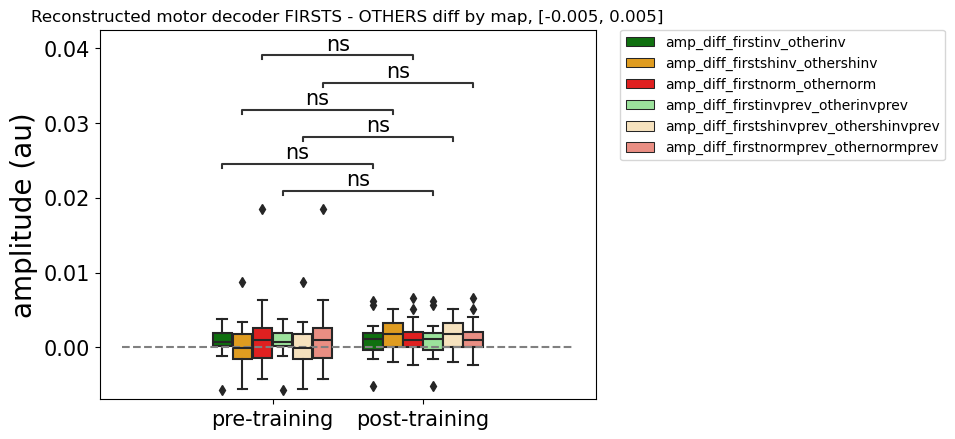

In [134]:


palette =  {'amp_diff_firstinv_otherinv':'green', 
            'amp_diff_firstshinv_othershinv': 'orange',
       'amp_diff_firstnorm_othernorm': 'red',
         'amp_diff_firstinvprev_otherinvprev':'lightgreen',
       'amp_diff_firstshinvprev_othershinvprev':'moccasin',
       'amp_diff_firstnormprev_othernormprev':'salmon'}

ax=sns.boxplot(pred_stim_df_sns, x = 'period', y = 'amplitude', hue = 'map', palette=palette)



pairs = [
 #   (("pre", "amp_diff_firstnorm_othernorm"), ("pre", "amp_diff_firstinv_otherinv")),
   # (("pre", "amp_diff_firstnormprev_othernormprev"), ("pre", "amp_diff_firstinvprev_otherinvprev")),

    # (("post", "amp_diff_firstnorm_othernorm"), ("post", "amp_diff_firstinv_otherinv")),
     (("pre", "amp_diff_firstinvprev_otherinvprev"), ("post", "amp_diff_firstinvprev_otherinvprev")),
      (("pre", "amp_diff_firstinv_otherinv"), ("post", "amp_diff_firstinv_otherinv")),
      (("pre", "amp_diff_firstshinvprev_othershinvprev"), ("post", "amp_diff_firstshinvprev_othershinvprev")),
      (("pre", "amp_diff_firstshinv_othershinv"), ("post", "amp_diff_firstshinv_othershinv")),
      (("pre", "amp_diff_firstnormprev_othernormprev"), ("post", "amp_diff_firstnormprev_othernormprev")),
      (("pre", "amp_diff_firstnorm_othernorm"), ("post", "amp_diff_firstnorm_othernorm"))
    #  (("post", "amp_diff_firstnormprev_othernormprev"), ("post", "amp_diff_firstinvprev_otherinvprev"))

    ]



annot = Annotator(ax, pairs, data=pred_stim_df_sns, x='period', y='amplitude', hue='map')
annot.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2, fontsize = 15)
annot.apply_and_annotate()
    
#formatting
plt.title(f'Reconstructed {train} decoder FIRSTS - OTHERS diff by map, {time_to_plot}')
plt.xlabel('')
#plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))
plt.yticks(fontsize=xtick_fontsize)
plt.xticks([0, 1], ['pre-training', 'post-training'], fontsize = xtick_fontsize)    
plt.ylabel('amplitude (au)', fontsize = axis_fontsize)
ax.hlines(0,-1, 2, linestyles = '--', color = 'grey')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

